In [7]:
!pip install spacy

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [9]:
!python -m spacy download es

     |████████████████████████████████| 16.2 MB 570 kB/s eta 0:00:01
  Created wheel for es-core-news-sm: filename=es_core_news_sm-2.3.1-py3-none-any.whl size=16216999 sha256=2a18a00de29f4e064a97173d03aeb895a6e5395541490a1e15b3366646a3fff0
  Stored in directory: /tmp/pip-ephem-wheel-cache-mk9rpowx/wheels/ef/67/82/0b6f50c9f4a2ad0e01633af17ece1d0bd8244f883385b1d9fa
Successfully built es-core-news-sm
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
✔ Linking successful
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/es_core_news_sm
-->
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/spacy/data/es
You can now load the model via spacy.load('es')


In [10]:
import numpy as np
import pandas as pd
import spacy
nlp = spacy.load('es', disable=['parser', 'ner'])  # make sure to use a larger model!


df = pd.read_excel('../Final Project/data.xlsx')
df.head()

df = df[((df["FUENTE"] != "CINESA OLD VERSION") & (df["FUENTE"] != "CINESA NEW VERSION") & (df["FUENTE"] != "THYSSEN "))]
df_long= pd.DataFrame(df["Codigo_new"].value_counts()>=30)
df_long["Label"]= df_long.index
df_long= df_long[df_long["Codigo_new"]]
list_of_labels = list(df_long["Label"])

#df = df[(df["Codigo_new"]== "POS") | (df["Codigo_new"]== "NEGATIVA")]

def long_short(x):
    if x in list_of_labels:
        return "Y"
    else:
        return "N"

df["Short_Long"] = df["Codigo_new"].apply(long_short)
df = df[df["Short_Long"] == "Y"]


df = df[(df["Codigo_new"]!= "POS") & (df["Codigo_new"]!= "NEGATIVA") & (df["Codigo_new"]!= "fsfs") & (df["Codigo_new"]!= "OTROS")]
#df = df[df["Codigo_new"]!= "OUT"]
#df = df[df["Codigo_new"]!= "FUERA"]
df = df[df["Codigo_new"]!= "OTROS"]
#df = df[df["Codigo_new"]!= "POS"]
#df = df[df["Codigo_new"]!= "NEGATIVA"]
#df = df[df["Codigo_new"]!= "GRUPOS"]
#df = df[df["Codigo_new"]!= "EXPLICACIONES"]
#df = df[df["Codigo_new"]!= "IDIOMAS"]

#df = df[(df["FUENTE"] != "CINESA OLD VERSION") | (df["FUENTE"] != "CINESA NEW VERSION") | (df["FUENTE"] != "THYSSEN")]
df= df.sort_values("Codigo_new")
from io import StringIO
col = ['Codigo_new', 'Comentarios_ES']
df = df[col]
df = df[pd.notnull(df['Comentarios_ES'])]
df.columns = ['Codigo_new', 'Comentarios_ES']
df['category_id'] = df['Codigo_new'].factorize()[0]
category_id_df = df[['Codigo_new', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Codigo_new']].values)
import unicodedata
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

splitter = lambda x: len(str(x).split())
splitter_letter = lambda x: len(str(x))
df["length_split"] = df["Comentarios_ES"].apply(splitter)
df["length_letters"] = df["Comentarios_ES"].apply(splitter_letter)  

def pos_tag(x):
    for i in df.index:
        if (df["length_split"].ix[i] == 1) & (df["length_letters"].ix[i]<=3):
            return "POS"
        else:
            return df["Codigo_new"].ix[i]
#df["Codigo_new"] = df["Codigo_new"].apply(pos_tag)

""" BAD WORDS 
def is_my_product(text):
    products = ["spaCy", "Thinc", "displaCy"]
    return text in products

MY_PRODUCT = nlp.vocab.add_flag(is_my_product)
doc = nlp("I like spaCy")
assert doc[2].check_flag(MY_PRODUCT) == True 
"""



df_ = df[(df["length_split"] == 1) & (df["length_letters"] > 4)]
df_.groupby("Codigo_new").mean()


,category_id,length_split,length_letters
Codigo_new,,,
COMIDA,0.0,1.0,6.733333
ESPERA,1.0,1.0,9.000000
FUERA,2.0,1.0,8.108434
INSTALACIONES,3.0,1.0,9.363636
LIMPIEZA,4.0,1.0,7.357143
NIÑOS,5.0,1.0,7.250000
PERSONAL,6.0,1.0,9.000000
PRECIOS,7.0,1.0,6.590909
PROGRAMACIÓN,8.0,1.0,7.571429


In [12]:
from sklearn.feature_extraction import text
from string import punctuation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#import spellchecker

all_stopword = list(stopwords.words("spanish")) + list(punctuation)
new_stop = ["res","dar","mes","més","molt","enfermo","dels","sin","menos","posar","tener","cada","cosa","cosas","mal","malo","pacient","paciente","pa","ma","mas","mes","el","per","en","amb","els","si","molt","la","un","muy","ser","por","lo","que","de","fa","tan"]

def removeStopwords(words):
    important_words=[]
    seperator = ' '
    for word in words.split():
        if word not in all_stopword:
            important_words.append(word)
    return seperator.join(important_words)


""" LOWER """
corpus = []
for i in df['Comentarios_ES'].index: #Numver of review len(df)
    review = df['Comentarios_ES'][i]
    review = str(review).lower()
    corpus.append(review)
df["CleanComment"]  = corpus

""" AUTO CORRECTOR"""
#from spellchecker import SpellChecker
#spell = SpellChecker(language="es")
#spell.word_frequency.load_words(['microsoft', 'apple', 'google'])
def autocorrector(x):
    misspelled = spell.unknown(str(x).split())
    sentence = x
    for wd in misspelled:
    # Get the one `most likely` answer
        sentence= sentence.replace(wd,spell.correction(wd))
    return sentence   
#df["Comentarios_ES"] = df["Comentarios_ES"].apply(autocorrector)

"""STOP WORDS """

df["CleanComment"] = df["CleanComment"].apply(removeStopwords)

""" REMOVE NAMES # doesnt work in catalan

comments= df["CleanComment"]
propn_clean = []
for sentence in comments:
    sentence = nlp(sentence)
    new_review= []

    for word in sentence:
        if word.pos_ !="PROPN":
            new_review.append(word.text)
    new_review= " ".join(new_review)
    propn_clean.append(new_review)
df["CleanComment"]  = propn_clean  """
     
def lemmatizacion(comment): # ,allowed_postags=['NOUN', 'ADJ', 'VERB',"PROPN"]
    phrase= []
    for word in comment.split():
        doc = nlp(word)
        #if doc[0].pos_ in allowed_postags:
        phrase.append(doc[0].lemma_)
    return " ".join(phrase)
df["CleanComment"] = df["CleanComment"].apply(lemmatizacion)


import re
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
corpus = []
for i in df['CleanComment'].index: #Numver of review len(df)
    review = df['CleanComment'][i]
    review = review.lower()
    review = review.split()
    ps = SnowballStemmer("spanish")
    review = [ps.stem(word) for word in review if not word in set(all_stopword)]
    review = ' '.join(review)
    corpus.append(review)
df['CleanComment'] = corpus
df["CleanComment"]= df["CleanComment"].apply(strip_accents)
corpus = []
for i in df['CleanComment'].index: #Numver of review len(df)
    review = re.sub('[^a-zA-Z]', ' ', df['CleanComment'][i])
    corpus.append(review)
df["CleanComment"]= corpus

from sklearn.model_selection import train_test_split

x= df["CleanComment"]
y= df["Codigo_new"]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#SLUG 
words =[]
for text in df["CleanComment"]:
    for word in text.split():
        words.append(word)
        
pd.DataFrame(words)[0].value_counts().to_excel("wordcount-CleanComment.xlsx")

#SLUG 
words =[]
for text in df["Comentarios_ES"]:
    for word in text.split():
        words.append(word)
        
pd.DataFrame(words)[0].value_counts().to_excel("wordcount.xlsx")


In [ ]:
""" SACAR NGRAMS"""
""" SACAR NGRAMS"""

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
counter = CountVectorizer(vocabulary=None,ngram_range=(2, 2), analyzer='word')
x_counter= counter.fit_transform(x)
terms =pd.DataFrame(x_counter.toarray(),columns=counter.get_feature_names()).sum()
terms.to_excel("ngram_count.xlsx")

In [13]:
from sklearn.metrics import confusion_matrix,classification_report,average_precision_score,precision_score,recall_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC


In [44]:
"""  LINEAR SVC GRIDSEARCH """


x_train_u, x_test_u, y_train_u, y_test_u =  train_test_split(x,y, test_size=0.3)

# compute n-grams of size 1 through 4
ngram_counter = TfidfVectorizer(vocabulary=None,ngram_range=(1, 1), analyzer='word')
x_train_u = ngram_counter.fit_transform(x_train_u)
x_test_u  = ngram_counter.transform(x_test_u)

from sklearn.model_selection import GridSearchCV

parameters = {'multi_class':['ovr', 'crammer_singer'],}

svc = LinearSVC()
text_clf = GridSearchCV(svc, parameters)
text_clf.fit(x_train_u,y_train_u)
text_clf.best_params_  
predictions_SVC = text_clf.predict(x_test_u)
print(classification_report(y_test_u,predictions_SVC))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


               precision    recall  f1-score   support

       COMIDA       0.94      0.91      0.92        53
       ESPERA       0.89      0.86      0.88       152
        FUERA       0.79      0.95      0.86       109
INSTALACIONES       0.77      0.69      0.73        94
     LIMPIEZA       0.97      0.85      0.91        34
        NIÑOS       0.76      0.81      0.79        16
     PERSONAL       0.82      0.81      0.81       173
      PRECIOS       0.86      0.83      0.85        36
 PROGRAMACIÓN       0.82      0.82      0.82        55

     accuracy                           0.84       722
    macro avg       0.85      0.84      0.84       722
 weighted avg       0.84      0.84      0.84       722



2186

In [14]:
"""  PIPELINE """
from sklearn.pipeline import Pipeline
x_train, x_test, y_train, y_test =  train_test_split(x,y, test_size=0.3,random_state= 217)


In [15]:
from sklearn import model_selection
import pickle
import itertools

import matplotlib.pyplot as plt
### MAX DEPTH (confusion_matrix(y_test,predictions)[0][0] / (confusion_matrix(y_test,predictions)[0][1] + confusion_matrix(y_test,predictions)[0][0]))*100
test_score_precision1 = []
test_score_prediction1 = []
train_score1 = []
test_score1 = []
for depth in range(1,2000,200):
    clf = Pipeline([("tfidf",TfidfVectorizer(vocabulary=dict(itertools.islice(vocab.items(), depth)),analyzer="word",lowercase=True)),("clf",LinearSVC())])
    clf.fit(x_train,y_train)
    #clf = DecisionTreeClassifier(max_depth=30,min_samples_leaf=depth)
    rfc_pred = clf.predict(x_test)
    train_score1.append(clf.score(x_train,y_train))
    test_score1.append(clf.score(x_test,y_test))
    #test_score.append((confusion_matrix(y_test,predictions)[0][0] / (confusion_matrix(y_test,predictions)[0][1] + confusion_matrix(y_test,predictions)[0][0])))
    #test_score_precision1.append(((confusion_matrix(y_test,rfc_pred)[0][0] + confusion_matrix(y_test,rfc_pred)[0][2]+ confusion_matrix(y_test,rfc_pred)[2][2] + confusion_matrix(y_test,rfc_pred)[2][0] ) ) /(confusion_matrix(y_test,rfc_pred)[0][0] + confusion_matrix(y_test,rfc_pred)[0][2]+ confusion_matrix(y_test,rfc_pred)[2][2] + confusion_matrix(y_test,rfc_pred)[2][0] + confusion_matrix(y_test,rfc_pred)[1][2]+ confusion_matrix(y_test,rfc_pred)[1][0]))
    #test_score_prediction1.append((confusion_matrix(y_test,rfc_pred)[0][0] + confusion_matrix(y_test,rfc_pred)[0][2]+ confusion_matrix(y_test,rfc_pred)[2][2] + confusion_matrix(y_test,rfc_pred)[2][0] )/ (confusion_matrix(y_test,rfc_pred)[0].sum() + confusion_matrix(y_test,rfc_pred)[2].sum()))

plt.figure(figsize = (8,8))
#plt.plot( range(1,2000,200),test_score_prediction1)
#plt.plot( range(1,2000,200), test_score_precision1)
plt.plot( range(1,2000,200), test_score1)
plt.plot( range(1,2000,200), train_score1)
plt.xlabel('Vocabulary words')
plt.ylabel('Accuracy')
plt.legend(["test_score","train_score"])

NameError: name 'vocab' is not defined

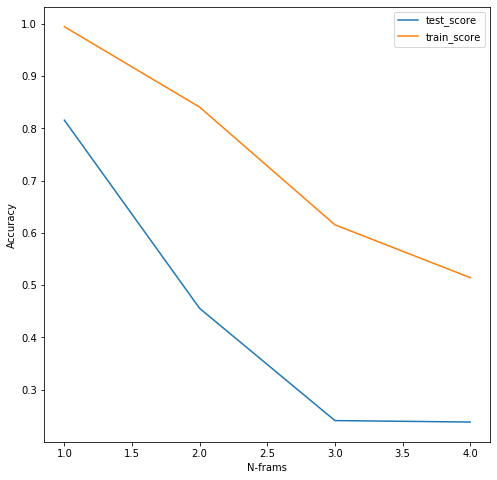

In [16]:

test_score_precision1 = []
test_score_prediction1 = []
train_score1 = []
test_score1 = []
for n in range(1,5,1):
    clf = Pipeline([("tfidf",TfidfVectorizer(ngram_range=(n,n),analyzer="word",lowercase=True)),("clf",LinearSVC())])
    clf.fit(x_train,y_train)
    #clf = DecisionTreeClassifier(max_depth=30,min_samples_leaf=depth)
    rfc_pred = clf.predict(x_test)
    train_score1.append(clf.score(x_train,y_train))
    test_score1.append(clf.score(x_test,y_test))
    #test_score.append((confusion_matrix(y_test,predictions)[0][0] / (confusion_matrix(y_test,predictions)[0][1] + confusion_matrix(y_test,predictions)[0][0])))
    #test_score_precision1.append(((confusion_matrix(y_test,rfc_pred)[0][0] + confusion_matrix(y_test,rfc_pred)[0][2]+ confusion_matrix(y_test,rfc_pred)[2][2] + confusion_matrix(y_test,rfc_pred)[2][0] ) ) /(confusion_matrix(y_test,rfc_pred)[0][0] + confusion_matrix(y_test,rfc_pred)[0][2]+ confusion_matrix(y_test,rfc_pred)[2][2] + confusion_matrix(y_test,rfc_pred)[2][0] + confusion_matrix(y_test,rfc_pred)[1][2]+ confusion_matrix(y_test,rfc_pred)[1][0]))
    #test_score_prediction1.append((confusion_matrix(y_test,rfc_pred)[0][0] + confusion_matrix(y_test,rfc_pred)[0][2]+ confusion_matrix(y_test,rfc_pred)[2][2] + confusion_matrix(y_test,rfc_pred)[2][0] )/ (confusion_matrix(y_test,rfc_pred)[0].sum() + confusion_matrix(y_test,rfc_pred)[2].sum()))

plt.figure(figsize = (8,8))
#plt.plot( range(1,2000,200),test_score_prediction1)
#plt.plot( range(1,2000,200), test_score_precision1)
plt.plot( range(1,5,1), test_score1)
plt.plot( range(1,5,1), train_score1)
plt.xlabel('N-frams')
plt.ylabel('Accuracy')
plt.legend(["test_score","train_score"])

In [18]:
text_clf = Pipeline([("tfidf",TfidfVectorizer(vocabulary=None,analyzer='word',ngram_range=(1,1))),("clf",LinearSVC())])

In [19]:
text_clf.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
               

In [20]:
predictions = text_clf.predict(x_test)
print(classification_report(y_test,predictions))

               precision    recall  f1-score   support

       COMIDA       0.90      0.81      0.85        68
       ESPERA       0.87      0.90      0.89       159
        FUERA       0.72      0.92      0.81        95
INSTALACIONES       0.85      0.61      0.71        98
     LIMPIEZA       0.91      0.70      0.79        30
        NIÑOS       0.57      0.73      0.64        11
     PERSONAL       0.76      0.82      0.79       168
      PRECIOS       0.88      0.82      0.85        34
 PROGRAMACIÓN       0.89      0.83      0.86        59

     accuracy                           0.82       722
    macro avg       0.82      0.79      0.80       722
 weighted avg       0.82      0.82      0.81       722



In [21]:
""" GET VOCABULARY BASED ON MODEL COEFICIENTS  """

def get_model_vocab(model,n_features):
    coefs = model.named_steps["clf"].coef_
    if type(coefs) =="csr_matrix":
        coefs.toarray().tolist()[0]
    else:
        coefs.tolist()
    feature_names = model.named_steps["tfidf"].get_feature_names()
    coefs_and_features = list(zip(coefs[0],feature_names))
    top_feats = sorted(coefs_and_features, key=lambda x: abs(x[0]), reverse=True)[:n_features]
    vocab = {x[1]: i for i, x in enumerate(top_feats)}
    return vocab

""" # Most positive features
sorted(coefs_and_features, key=lambda x: x[0], reverse=True)
# Most negative features
sorted(coefs_and_features, key=lambda x: x[0])
# Most predictive overall
sorted(coefs_and_features, key=lambda x: abs(x[0]), reverse=True)"""


' # Most positive features\nsorted(coefs_and_features, key=lambda x: x[0], reverse=True)\n# Most negative features\nsorted(coefs_and_features, key=lambda x: x[0])\n# Most predictive overall\nsorted(coefs_and_features, key=lambda x: abs(x[0]), reverse=True)'

In [ ]:

vocab = get_model_vocab(text_clf,1000)

In [22]:
""" UPDATE VOCABULARY WITH  N-GRAMS """
def update_vocabulary(string):
    """ UPDATE VOCABULARY WITH  N-GRAMS """
    vocab_2ngram = string.split(",")
    vocab_2ngram_dict = {}
    for i,word in zip(range(len(vocab),len(vocab)+len(vocab_2ngram)),vocab_2ngram):
        vocab_2ngram_dict.update({word:i})
    vocab_2ngram_dict
    vocab.update(vocab_2ngram_dict)
    return vocab

string = "urgenci esper,tiemp esper,temps esper,sal esper,personal medic,hor esper,esper urgenci,falt personal,list esper,cambi personal,esper consult,esper hor,air acondicion,do hor,esper visit,necesit personal,baix preus,buen atencion,esper demasi,esper sal,trat human,varied product,atencion client"

In [116]:
""" Transform string text to a format that the model can read """
def comment_processing(comment):
    """ Transform string text to a format that the model can read """
    corpus = []
    review = comment.lower()
    #ps = SnowballStemmer("spanish")

    review=" ".join([lemmatizacion(word) for word in review.split()])

    review=" ".join([ps.stem(word) for word in review.split()])
    review = strip_accents(review)
    corpus.append(review)

    comment  = corpus
    comment = pd.DataFrame([comment])[0].apply(removeStopwords)
    comment= comment[0]

    corpus = []
    review = re.sub('[^a-zA-Z]', ' ', comment)
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review]
    review = ' '.join(review)
    corpus.append(review)
    comment = corpus[0]
    comment = pd.DataFrame([comment])[0].apply(removeStopwords)
    comment= comment[0]
    return [comment]


In [120]:
string = comment_processing("los baños estaban muy sucios")

In [121]:
text_clf.predict(string)

array(['LIMPIEZA'], dtype=object)

In [128]:
pd.concat([pd.DataFrame(y_train.values),pd.DataFrame(x_train_u.toarray())],axis=1)

,0,0,1,2,3,4,5,6,7,8,...,2176,2177,2178,2179,2180,2181,2182,2183,2184,2185
0,INSTALACIONES,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,PERSONAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,LIMPIEZA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,COMIDA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,COMIDA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,INSTALACIONES,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1679,FUERA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1680,ESPERA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1681,ESPERA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
len(y_train)

1683

In [231]:
ngram_counter = TfidfVectorizer(vocabulary=None,ngram_range=(1, 1), analyzer='word')
x_train_u = ngram_counter.fit_transform(x_train)
x_test_u  = ngram_counter.transform(x_test)

train_data = pd.concat([pd.DataFrame(y_train.values),pd.DataFrame(x_train_u.toarray())],axis=1)
test_data = pd.concat([pd.DataFrame(y_test.values),pd.DataFrame(x_test_u.toarray())],axis=1)


In [233]:
train_data_y= train_data.iloc[:,0]
train_data_x= train_data.iloc[:,1:]

test_data_y= test_data.iloc[:,0]
test_data_x= test_data.iloc[:,1:]


In [234]:
import os
def make_csv(x, y, filename, data_dir):
    '''Merges features and labels and converts them into one csv file with labels in the first column.
       :param x: Data features
       :param y: Data labels
       :param file_name: Name of csv file, ex. 'train.csv'
       :param data_dir: The directory where files will be saved
       '''
    # make data dir, if it does not exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    
    # your code here
    df = pd.concat([pd.DataFrame(y),pd.DataFrame(x)],axis=1)
    df.to_csv(os.path.join(data_dir,filename),index=False,header=False)
    
    # nothing is returned, but a print statement indicates that the function has run
    print('Path created: '+str(data_dir)+'/'+str(filename))
    return df

In [36]:
#make_csv(x_train,y_train,"train.csv","Label_predictor")

Path created: Label_predictor/train.csv


In [235]:
make_csv(test_data_x,test_data_y,"test.csv","Label_predictor")

Path created: Label_predictor/test.csv


,0,0,1,2,3,4,5,6,7,8,...,2176,2177,2178,2179,2180,2181,2182,2183,2184,2185
0,COMIDA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,INSTALACIONES,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,PROGRAMACIÓN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,PERSONAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,INSTALACIONES,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,PERSONAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
718,FUERA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
719,FUERA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
720,PERSONAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [207]:
make_csv(train_data_x,train_data_y,"train.csv","Label_predictor")

Path created: Label_predictor/train.csv


,0,0,1,2,3,4,5,6,7,8,...,2176,2177,2178,2179,2180,2181,2182,2183,2184,2185
0,INSTALACIONES,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,PERSONAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,LIMPIEZA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,COMIDA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,COMIDA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,INSTALACIONES,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1679,FUERA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1680,ESPERA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1681,ESPERA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [176]:

import pandas as pd
import boto3
import sagemaker

In [177]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

In [208]:

# should be the name of directory you created to save your features data
data_dir = 'Label_predictor'

# set prefix, a descriptive name for a directory  
prefix = 'Label_predictor'

# upload all data to S3 
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print(input_data)

s3://sagemaker-eu-central-1-915492785002/Label_predictor


In [209]:

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# confirm that data is in S3 bucket
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')

Label_predictor/test.csv
Label_predictor/train.csv
Label_predictor/train2.csv
plagiarism/train.csv
sagemaker-scikit-learn-2020-10-13-14-46-07-889/debug-output/training_job_end.ts
sagemaker-scikit-learn-2020-10-13-14-46-07-889/source/sourcedir.tar.gz
sagemaker-scikit-learn-2020-10-13-15-45-53-769/source/sourcedir.tar.gz
sagemaker-scikit-learn-2020-10-13-15-51-45-689/source/sourcedir.tar.gz
sagemaker-scikit-learn-2020-10-13-15-55-24-411/source/sourcedir.tar.gz
sagemaker-scikit-learn-2020-10-13-15-59-26-028/source/sourcedir.tar.gz
sagemaker-scikit-learn-2020-10-13-16-16-33-182/source/sourcedir.tar.gz
sagemaker-scikit-learn-2020-10-13-16-28-36-829/source/sourcedir.tar.gz
sagemaker-scikit-learn-2020-10-13-16-34-23-451/source/sourcedir.tar.gz
sagemaker-scikit-learn-2020-10-13-16-38-48-306/debug-output/training_job_end.ts
sagemaker-scikit-learn-2020-10-13-16-38-48-306/output/model.tar.gz
sagemaker-scikit-learn-2020-10-13-16-38-48-306/source/sourcedir.tar.gz
sagemaker-scikit-learn-2020-10-13-1

In [210]:

from sagemaker.sklearn.estimator import SKLearn

estimator = SKLearn(entry_point="train.py",
                    source_dir="source_train",
                    role=role,
                    train_instance_count=1,
                    train_instance_type='ml.c5.xlarge',
                   sagemaker_session=sagemaker_session)

This is not the latest supported version. If you would like to use version 0.23-1, please add framework_version=0.23-1 to your constructor.


In [211]:
!pygmentize source_train/train.py

from __future__ import print_function

import argparse
import os
import pandas as pd
from sklearn.pipeline import Pipeline

from sklearn.externals import joblib

## TODO: Import any additional libraries you need to define a model
from sklearn.svm import LinearSVC

# Provided model load function
def model_fn(model_dir):
    """Load model from the model_dir. This is the same model that is saved
    in the main if statement.
    """
    print("Loading model.")
    
    # load using joblib
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    print("Done loading model.")
    
    return model


## TODO: Complete the main code
if __name__ == '__main__':
    
    # All of the model parameters and training parameters are sent as arguments
    # when this script is executed, during a training job
    
    # Here we set up an argument parser to easily access the parameters
    parser = argparse.ArgumentParser()

    # SageMaker parameters, like the directories for training data a

In [214]:
#training = pd.read_csv(os.path.join(data_dir,"train.csv"),header=None,names=None)

In [215]:
training = sagemaker_session.upload_data(os.path.join(data_dir,"train.csv"),bucket=bucket, key_prefix=prefix)
print(training)

s3://sagemaker-eu-central-1-915492785002/Label_predictor/train.csv


In [216]:
%%time

# Train your estimator on S3 training data
estimator.fit({'train': training})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-10-13 16:56:20 Starting - Starting the training job...
2020-10-13 16:56:22 Starting - Launching requested ML instances......
2020-10-13 16:57:37 Starting - Preparing the instances for training......
2020-10-13 16:58:49 Downloading - Downloading input data
2020-10-13 16:58:49 Training - Training image download completed. Training in progress..2020-10-13 16:58:50,537 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2020-10-13 16:58:50,539 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-10-13 16:58:50,548 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-10-13 16:58:50,761 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-10-13 16:58:50,761 sagemaker-containers INFO     Generating setup.cfg
2020-10-13 16:58:50,761 sagemaker-containers INFO     Generating MANIFEST.in
2020-10-13 16:58:50,762 sagemaker-containers INFO     Installing modul

In [217]:

%%time

# uncomment, if needed
# from sagemaker.pytorch import PyTorchModel

# deploy your model to create a predictor
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!CPU times: user 282 ms, sys: 4.3 ms, total: 286 ms
Wall time: 7min 32s


In [257]:
# read in test data, assuming it is stored locally
test_data = pd.read_csv(os.path.join(data_dir, "test.csv"), header=None, names=None)
test_data_y= test_data.iloc[:,0]
test_data_x= test_data.iloc[:,1:]
# labels are in the first column


In [265]:
test_y_preds = predictor.predict([test_data_x.values])

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from model with message "<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>500 Internal Server Error</title>
<h1>Internal Server Error</h1>
<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>
". See https://eu-central-1.console.aws.amazon.com/cloudwatch/home?region=eu-central-1#logEventViewer:group=/aws/sagemaker/Endpoints/sagemaker-scikit-learn-2020-10-13-16-56-20-347 in account 915492785002 for more information.

In [252]:
test_data_x.loc[0].values.reshape(-1,1)

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])